In [10]:
import torch
from transformers import AutoModelForVision2Seq, AutoProcessor, BitsAndBytesConfig
from datasets import load_dataset
from peft import LoraConfig
from trl import SFTConfig, SFTTrainer
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import random
import io
import random
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image


In [2]:
# 1. Configure 4-bit quantization
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=False,
    bnb_4bit_compute_dtype=torch.bfloat16
)

In [3]:
# 2. Load the Llama-3.2-11B-Vision model with quantization
model_name = "meta-llama/Llama-3.2-11B-Vision-Instruct"
model = AutoModelForVision2Seq.from_pretrained(
    model_name,
    device_map="auto",
    torch_dtype=torch.bfloat16,
    quantization_config=bnb_config
)
model.config.use_cache = False

The model weights are not tied. Please use the `tie_weights` method before using the `infer_auto_device` function.
Loading checkpoint shards: 100%|██████████| 5/5 [00:05<00:00,  1.17s/it]


In [4]:
# 3. Load the processor
processor = AutoProcessor.from_pretrained(model_name)

In [5]:
# 4. Load dataset and preprocess data
transform = transforms.Compose([
    transforms.Resize((500, 500)),  # 統一圖片大小
    transforms.RandomApply([transforms.RandomHorizontalFlip()], p=0.15),  # 水平翻轉
    transforms.RandomApply([transforms.RandomAffine(degrees=15, translate=(0.1, 0.1))], p=0.10),  # 拍歪
    transforms.RandomApply([transforms.RandomAffine(degrees=30, translate=(0.1, 0.1))], p=0.10),  # 拍歪
    transforms.RandomApply([transforms.RandomAffine(degrees=45, translate=(0.1, 0.1))], p=0.10),  # 拍歪
    transforms.RandomApply([transforms.GaussianBlur(21, 10)], p=0.15),  # 模糊
])

# Prompt 模板
prompt = """You are an expert e-commerce content writer specializing in SEO-optimized and mobile-friendly product descriptions.

Follow these steps to analyze and generate the product description:

### Step 1: Analyze the provided product image and extract key visual details, including:
- Colors, materials, and unique design features.
- Brand name or visible unique identifiers.
- Intended use or relevant category.

### Step 2: Combine the image analysis with the provided product information:
- PRODUCT NAME: {product_name}
- CATEGORY: {category}

### Step 3: Generate a concise, engaging, and SEO-optimized product description:
- Use simple and clear language for a better mobile search experience.
- Naturally include visual details (e.g., colors, material) to make the description accurate and informative.
- Keep the description under 50 words.

**Input**:
- Product Image: [Provided image]
- PRODUCT NAME: {product_name}
- CATEGORY: {category}

**Output**:
Write **only the description text.**
"""

# 定義處理單個樣本的函數
def format_data(sample):
    # 格式化輸入與輸出
    return {
        "messages": [
            {
                "role": "user",
                "content": [
                    {
                        "type": "text",
                        "text": prompt.format(product_name=sample["Product Name"], category=sample["Category"]),
                    },
                    {
                        "type": "image",
                        "image": transform(sample["image"]),
                    }
                ],
            },
            {
                "role": "assistant",
                "content": [{"type": "text", "text": sample["description"]}],
            },
        ],
    }

# 加載資料集並格式化
dataset_id = "philschmid/amazon-product-descriptions-vlm"
raw_dataset = load_dataset(dataset_id, split="train")
dataset = [format_data(sample) for sample in raw_dataset]

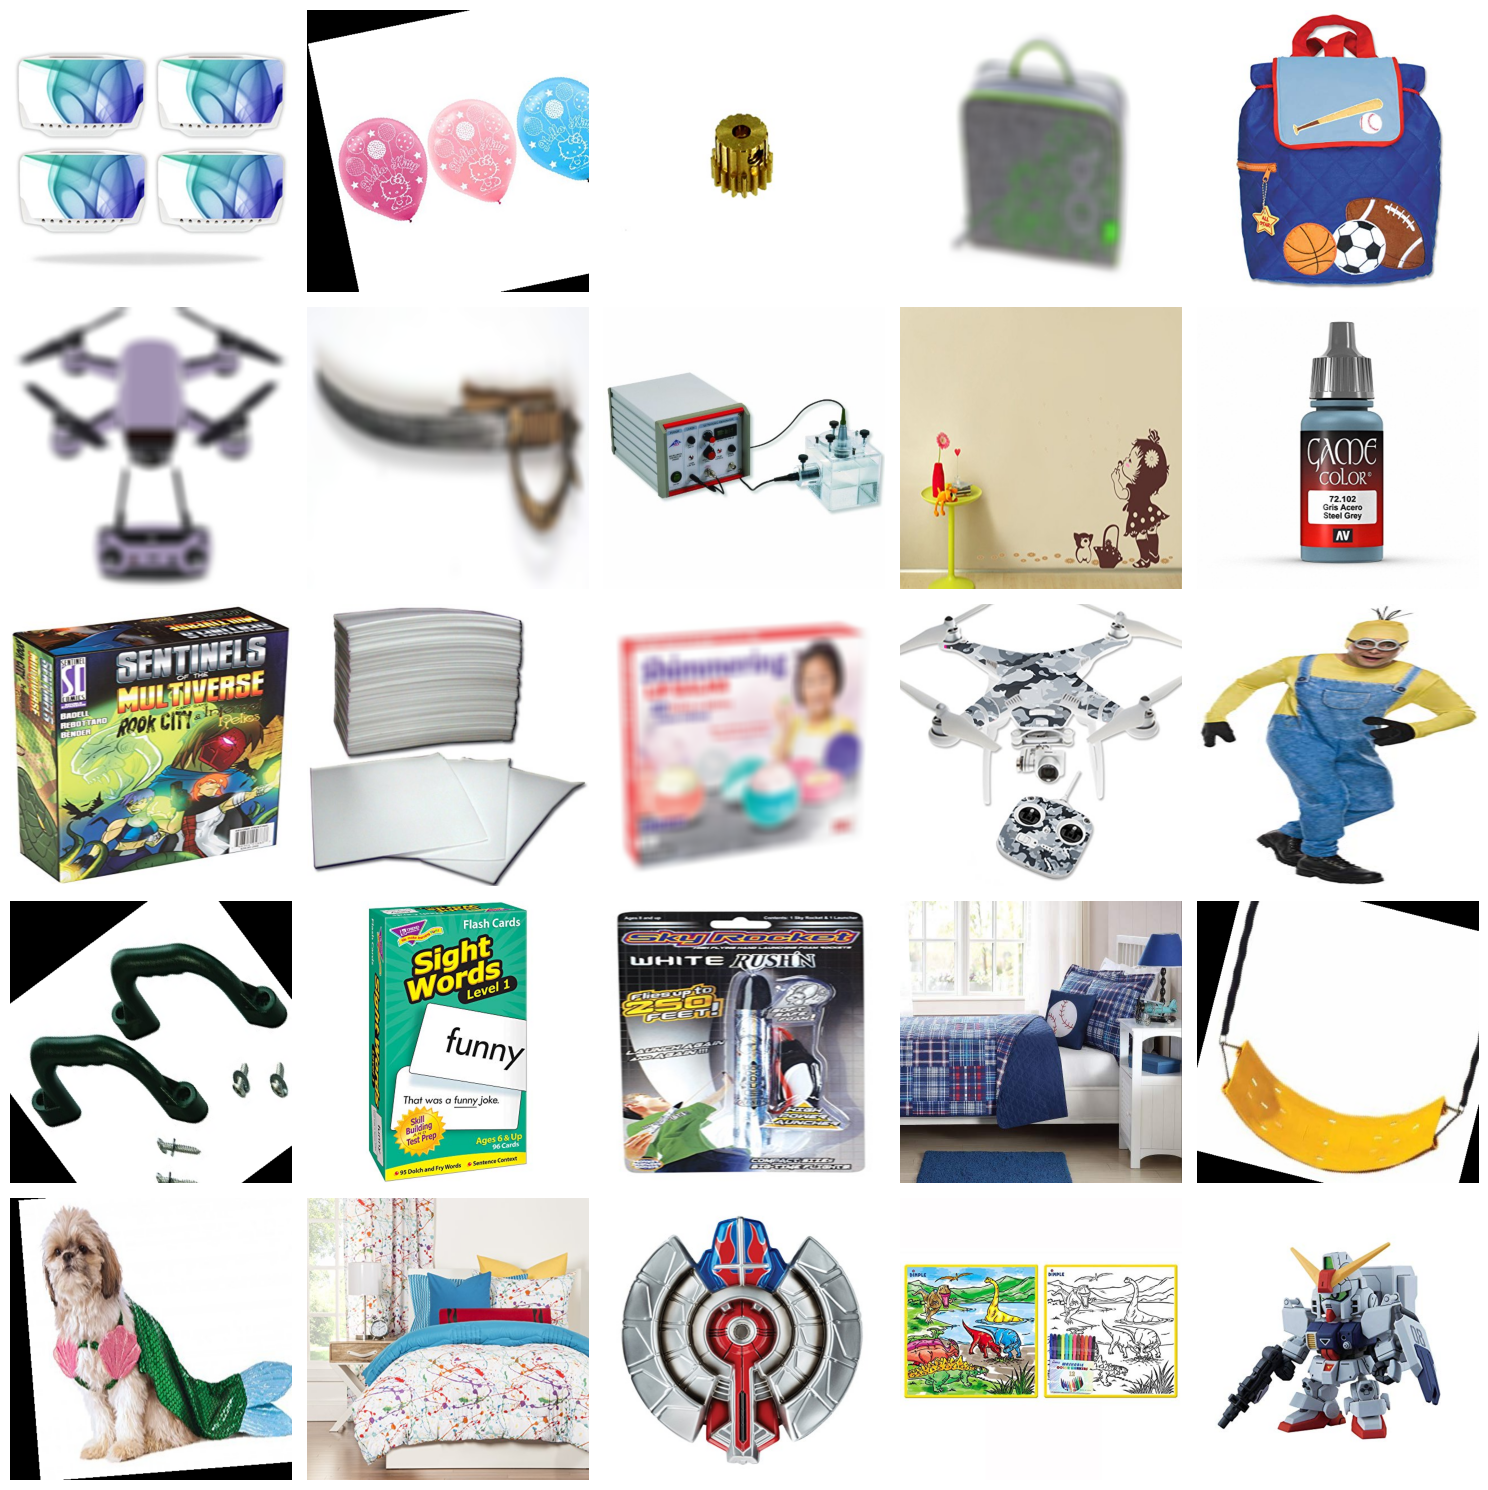

In [14]:
def visualize_random_images(dataset, num_images=25):
    selected_samples = random.sample(dataset, num_images)
    
    fig, axes = plt.subplots(5, 5, figsize=(15, 15))
    
    for idx, ax in enumerate(axes.flatten()):
        image = selected_samples[idx]["messages"][0]["content"][1]["image"]
        
        ax.imshow(image)
        ax.axis("off")
    
    plt.tight_layout()
    plt.show()

visualize_random_images(dataset, num_images=25)

In [15]:
# 6. Configure LoRA
peft_config = LoraConfig(
    lora_alpha=16,
    lora_dropout=0.1,
    r=8,
    bias="none",
    target_modules=["q_proj", "v_proj"],
    task_type="CAUSAL_LM"
)

In [16]:
# 7. Define SFT Training Arguments
sft_args = SFTConfig(
    output_dir="./llama-3.2-11b-vision-finetuned",
    num_train_epochs=5,
    per_device_train_batch_size=4,
    gradient_accumulation_steps=2,
    max_seq_length=512,
    logging_steps=100,
    learning_rate=2e-5,
    fp16=False,
    bf16=True,
    max_grad_norm=1.0,
    warmup_ratio=0.1,
    weight_decay=0.01,
    gradient_checkpointing=True,
    optim="paged_adamw_32bit",
    save_strategy="epoch",
    lr_scheduler_type="cosine",
    report_to="tensorboard",
    remove_unused_columns=False,
    gradient_checkpointing_kwargs={"use_reentrant": False},
    dataset_kwargs={"skip_prepare_dataset": True},
    use_liger=True
)

In [17]:
# 8. Define data collator
def collate_fn(examples):
    texts = [processor.apply_chat_template(example["messages"], tokenize=False) for example in examples]
    image_inputs = [example["messages"][0]['content'][1]['image'] for example in examples]

    batch = processor(
        text=texts,
        images=image_inputs,
        return_tensors="pt",
        add_special_tokens=False,
        padding=True
    )

    # Mask padding and image tokens in labels
    labels = batch["input_ids"].clone()
    labels[labels == processor.tokenizer.pad_token_id] = -100
    labels[labels == processor.image_token_id] = -100
    batch["labels"] = labels

    return batch

In [18]:
# 9. Initialize the Trainer
trainer = SFTTrainer(
    model=model,
    args=sft_args,
    train_dataset=dataset,
    data_collator=collate_fn,
    peft_config=peft_config,
    tokenizer=processor.tokenizer,
)


In [19]:
# 10. Fine-tune the model
if torch.cuda.is_available():
    print("CUDA available. Starting training...")
    trainer.train()
else:
    print("CUDA not available. Training on CPU. This may take longer.")

# 10. Save the fine-tuned model
trainer.save_model("./llama-3.2-11b-vision-finetuned")
print("Model saved successfully.")

CUDA available. Starting training...


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.


Step,Training Loss
100,2.574400
200,0.815000
300,0.443900
400,0.400800
500,0.386700
600,0.375000
700,0.371400
800,0.370200


Model saved successfully.
